In [20]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#!unzip test_dir_fin.zip
#!unzip dataset.zip

Archive:  dataset.zip
   creating: tr_dir/
   creating: tr_dir/No/
  inflating: tr_dir/No/1 no.jpeg     
  inflating: tr_dir/No/10 no.jpg     
  inflating: tr_dir/No/11 no.jpg     
  inflating: tr_dir/No/12 no.jpg     
  inflating: tr_dir/No/13 no.jpg     
  inflating: tr_dir/No/14 no.jpg     
  inflating: tr_dir/No/15 no.jpg     
  inflating: tr_dir/No/17 no.jpg     
  inflating: tr_dir/No/18 no.jpg     
  inflating: tr_dir/No/19 no.jpg     
  inflating: tr_dir/No/2 no.jpeg     
  inflating: tr_dir/No/20 no.jpg     
  inflating: tr_dir/No/21 no.jpg     
  inflating: tr_dir/No/22 no.jpg     
  inflating: tr_dir/No/23 no.jpg     
  inflating: tr_dir/No/24 no.jpg     
  inflating: tr_dir/No/25 no.jpg     
  inflating: tr_dir/No/26 no.jpg     
  inflating: tr_dir/No/27 no.jpg     
  inflating: tr_dir/No/28 no.jpg     
  inflating: tr_dir/No/29 no.jpg     
  inflating: tr_dir/No/3 no.jpg      
  inflating: tr_dir/No/30 no.jpg     
  inflating: tr_dir/No/31 no.jpg     
  inflating: tr_dir/N

  inflating: ts_dir/Yes/Y17.jpg      
  inflating: ts_dir/Yes/Y18.JPG      
  inflating: ts_dir/Yes/Y19.JPG      
  inflating: ts_dir/Yes/Y2.jpg       
  inflating: ts_dir/Yes/Y20.jpg      
  inflating: ts_dir/Yes/Y21.jpg      
  inflating: ts_dir/Yes/Y3.jpg       
  inflating: ts_dir/Yes/Y4.jpg       
  inflating: ts_dir/Yes/Y7.jpg       
  inflating: ts_dir/Yes/Y9.jpg       
   creating: vl_dir/
   creating: vl_dir/No/
  inflating: vl_dir/No/no 90.jpg     
  inflating: vl_dir/No/no 91.jpeg    
  inflating: vl_dir/No/no 99.jpg     
  inflating: vl_dir/No/No15.jpg      
  inflating: vl_dir/No/No22.jpg      
   creating: vl_dir/Yes/
  inflating: vl_dir/Yes/Y1.jpg       
  inflating: vl_dir/Yes/Y10.jpg      
  inflating: vl_dir/Yes/Y259.JPG     
  inflating: vl_dir/Yes/Y6.jpg       
  inflating: vl_dir/Yes/Y8.jpg       


In [6]:
!nvidia-smi

Fri Nov 12 22:41:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   33C    P0    57W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
#Резервирование видеокарты
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2' 

In [21]:
# Размер изображения
image_size = 224
IMG_SIZE = (224,224)
# Размер мини-выборки
batch_size = 16
# Размерность тензора на основе изображения для входных данных в нейронную сеть
input_shape = (image_size, image_size, 3)

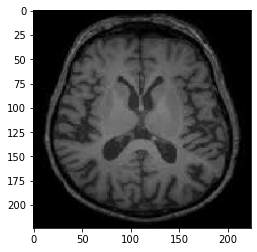

In [22]:
img_path = 'tr_dir/No/10 no.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

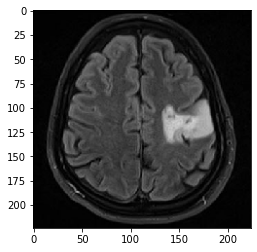

In [23]:
img_path = 'tr_dir/Yes/Y50.JPG'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [24]:
#Создаем генераторы изображений

# Каталог с данными для обучения
train_dir = 'tr_dir'
test_dir= 'vl_dir'
norm_dir = 'tr/No'
tumor_dir = 'tr/Yes'


train_datagen = ImageDataGenerator(
    rescale=1. / 255,                       #деление каждого пикселя на 255
    rotation_range=10,                      #поворот изображения
    width_shift_range=0.05,                 #сдвиг по горизонтали
    height_shift_range=0.05,                #сдвиг по вертикали 
    zoom_range=0.1,                         #изменение размеров
    shear_range=0.1,                        #диапазон сдвига
    brightness_range=[0.5, 1.5],            #изменение яркости(<1 - затемнение, >1 - увеличение яркости)
    horizontal_flip=True,                   #поворот относительно оси y на 180°
    vertical_flip=True,                     #поворот относительно оси x на 180°
    preprocessing_function=preprocess_input,#функция применяемая на каждом шаге
    fill_mode='nearest'                     #правило заполнения точек за пределами границы входных изображений
)


test_datagen = ImageDataGenerator(
    rescale=1. / 255,                                              
    preprocessing_function=preprocess_input                          
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary'
)

Found 208 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


In [25]:
#Номера классов в генераторах
print(validation_generator.class_indices)
print(train_generator.class_indices)

{'No': 0, 'Yes': 1}
{'No': 0, 'Yes': 1}


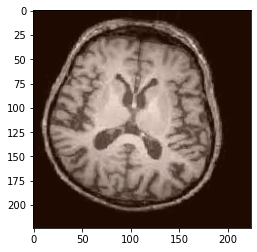

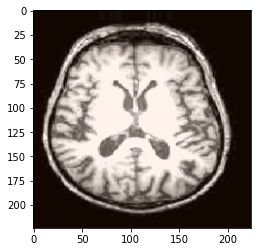

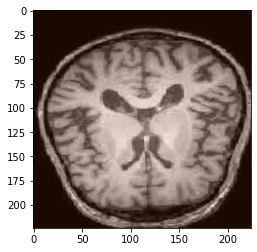

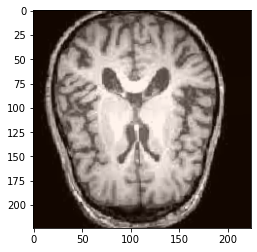

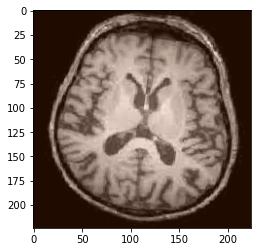

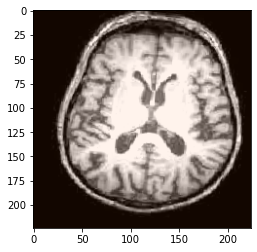

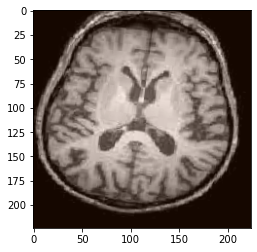

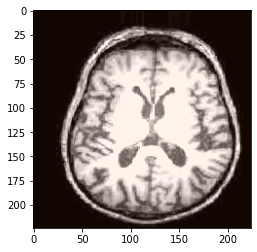

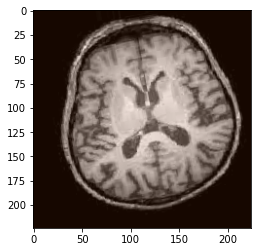

In [26]:
#Проверка генератора
img_path = 'tr_dir/No/10 no.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 9 == 0:
        break
plt.show()

In [27]:
#Загружаем предварительно обученную нейронную сеть VGG19
pretrained_model = VGG19(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))

In [28]:
#Структура нейронной сети
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
# Заморозка нижних слоев
for layer in pretrained_model.layers[15:]:
    layer.trainable = False

In [31]:
#Создаем составную нейронную сеть
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, 
              outputs=predictions)

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

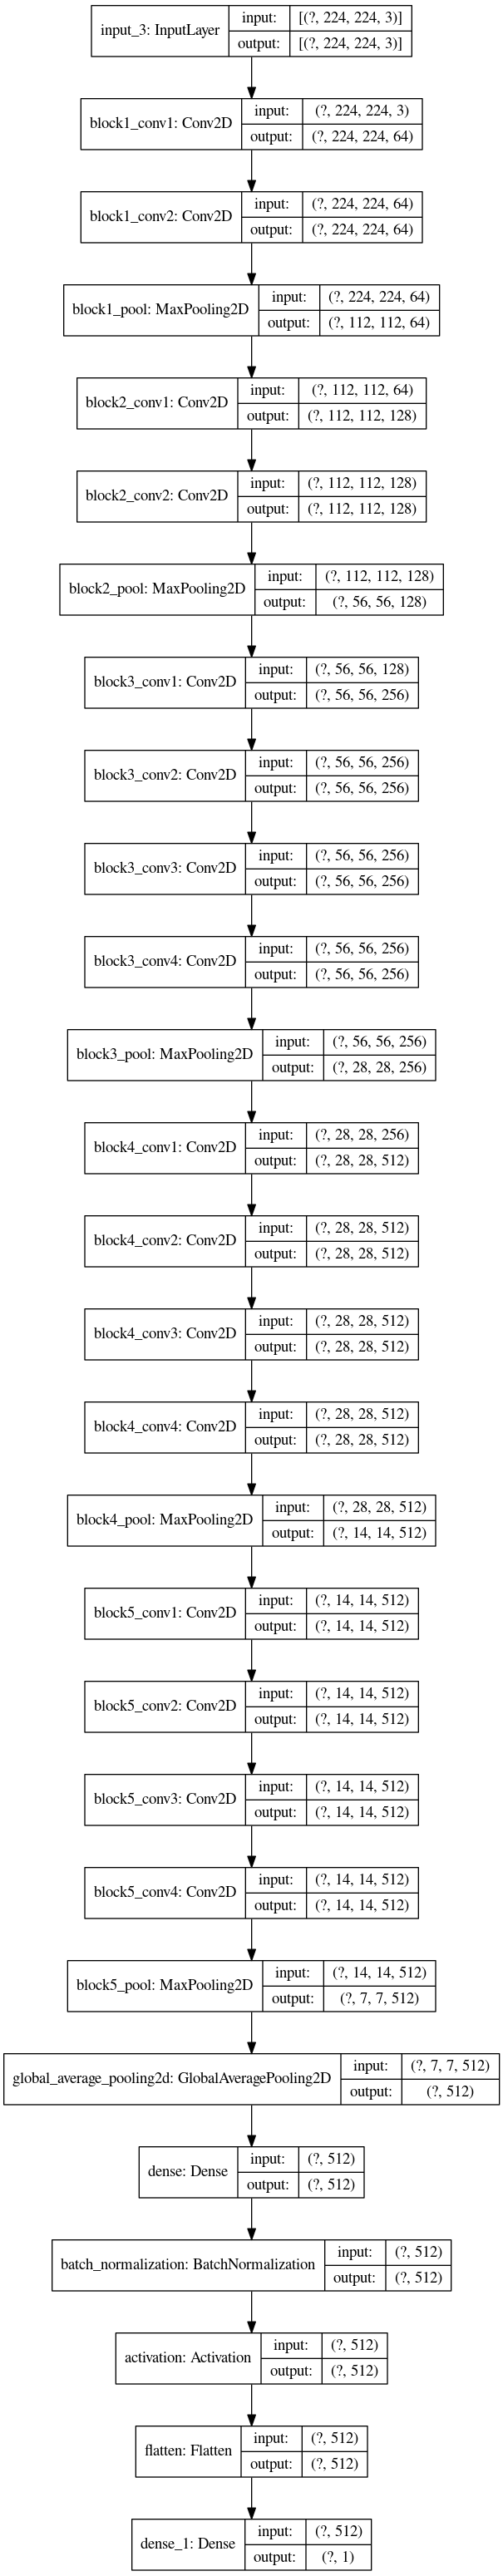

In [45]:
#print(history.history.keys())
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg'))
import pydot

#(graph,) = pydot.graph_from_dot_file('somefile.dot')
#graph.write_png('somefile.png')
plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)
#dot_img_file = '/tmp/model_1.png'
#tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

filepath="VGG19_best.h5"

#Сохранение нейронной сети если доля правильных ответов на проверочном наборе данных
#лучше чем на предыдущих этапах
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#Замедление скорости обучения, если в течении трех эпох
#если не изменяется доля правильных ответов на проверочном наборе данных
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', #наболюдаемый параметр
                                            patience=3,             #кол-во эпох после которых происходит остановка
                                            verbose=1,              #подробное отображения процесса обучения
                                            factor=0.5,             #коэффицент на который будет снижена скорость обучения(lr*factor)
                                            min_lr=0.00001)         #нижняя граница скорости обучения

#колбэк на остановку обучения если точность распознавания проверочной выборки не улушается
es = EarlyStopping(
    monitor='val_accuracy',  
    mode='max',              
    patience=8               
)

callbacks_list = [es, checkpoint,learning_rate_reduction]            #список колбэков 

In [27]:
EPOCHS = 40

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,                     
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,                    
    callbacks=callbacks_list
)

Epoch 1/40
49/50 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.6987
Epoch 00001: val_accuracy improved from -inf to 0.49379, saving model to VGG19_best4.h5
50/50 [==============================] - 28s 560ms/step - loss: 0.5937 - accuracy: 0.6987 - val_loss: 0.8746 - val_accuracy: 0.4938
Epoch 2/40
49/50 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.7507
Epoch 00002: val_accuracy improved from 0.49379 to 0.51863, saving model to VGG19_best4.h5
50/50 [==============================] - 23s 465ms/step - loss: 0.4806 - accuracy: 0.7520 - val_loss: 7.0061 - val_accuracy: 0.5186
Epoch 3/40
49/50 [============================>.] - ETA: 0s - loss: 0.4302 - accuracy: 0.8020
Epoch 00003: val_accuracy did not improve from 0.51863
50/50 [==============================] - 22s 431ms/step - loss: 0.4282 - accuracy: 0.8029 - val_loss: 7.6531 - val_accuracy: 0.5124
Epoch 4/40
49/50 [============================>.] - ETA: 0s - loss: 0.3830 - accuracy: 0

Epoch 28/40
49/50 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.98137
50/50 [==============================] - 22s 436ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2546 - val_accuracy: 0.9224
Epoch 29/40
49/50 [============================>.] - ETA: 0s - loss: 8.2225e-04 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.98137
50/50 [==============================] - 21s 423ms/step - loss: 8.0905e-04 - accuracy: 1.0000 - val_loss: 0.2851 - val_accuracy: 0.9596
Epoch 30/40
49/50 [============================>.] - ETA: 0s - loss: 6.2433e-04 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.98137
50/50 [==============================] - 22s 443ms/step - loss: 6.1507e-04 - accuracy: 1.0000 - val_loss: 0.3863 - val_accuracy: 0.9037
Epoch 31/40
49/50 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve f

In [28]:
import pandas as pd
import numpy as np

pr_Hist=pd.DataFrame.from_dict(history.history)
pr_Hist.tail(10)

,loss,accuracy,val_loss,val_accuracy,lr
21,0.005201,0.999308,0.291574,0.919255,0.000012
22,0.013663,0.996489,0.117073,0.981366,0.000012
23,0.002199,1.000000,0.139104,0.959627,0.000012
24,0.001944,0.999298,1.652788,0.760870,0.000012
25,0.003520,0.999308,0.191234,0.944099,0.000012
26,0.001011,1.000000,0.308268,0.903727,0.000010
27,0.001975,1.000000,0.254616,0.922360,0.000010
28,0.000693,1.000000,0.285104,0.959627,0.000010
29,0.000656,1.000000,0.386306,0.903727,0.000010
30,0.001013,1.000000,0.358522,0.919255,0.000010


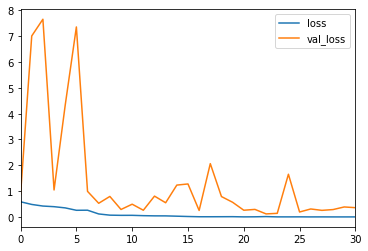

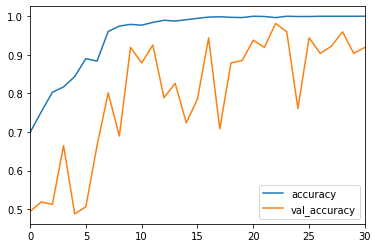

In [29]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [1]:
#Тестируем модель
#загрузка обученной модели
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

model = load_model('VGG19_best.h5')

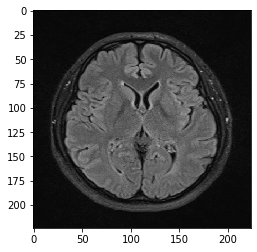

In [7]:
image_size = 224
#Загружаем изображение  
#img_path = 'ts_dir/No/no 90.jpg' 
img_path = 'ts_dir/No/no 91.jpeg' 
#img_path = 'ts_dir/No/no 99.jpg' 
#img_path = 'ts_dir/No/No15.jpg' 
#img_path = 'ts_dir/No/No22.jpg' 
#img_path = 'ts_dir/Yes/Y1.jpg' 
#img_path = 'ts_dir/Yes/Y10.jpg' 
#img_path = 'ts_dir/Yes/Y259.JPG' 
#img_path = 'ts_dir/Yes/Y6.jpg' 
#img_path = 'ts_dir/Yes/Y8.jpg' 
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [8]:
#Преобразуем изображение в массив для распознавания
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [9]:
#Запускаем распознавание
prediction = model.predict(x)

In [16]:
#Номера классов в генераторах#Распознавание
validation_generator.class_indices

{'No': 0, 'Yes': 1}

In [10]:
prediction

array([[0.61783576]], dtype=float32)

In [11]:
if prediction[[0]] < 0.5:
    print('Normal')
else:
    print('Tumor')

Tumor
